# TP5 - Morphologie Mathématique

Ce notebook implémente les opérations de morphologie mathématique:
1. **Dilatation** - Agrandit les objets (maximum local)
2. **Érosion** - Réduit les objets (minimum local)
3. **Ouverture** - Érosion puis dilatation (supprime petits éléments)
4. **Fermeture** - Dilatation puis érosion (bouche les trous)
5. **Gradient morphologique** - Dilatation - Érosion (détection de contours)

In [4]:
# Imports et fonctions utilitaires
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os


def load_binary_image(filename: str) -> np.ndarray:

    # Chercher l'image dans plusieurs emplacements possibles
    paths_to_try = [
        filename,
        os.path.join('..', 'originals', filename),
        os.path.join('originals', filename),
    ]
    
    for path in paths_to_try:
        if os.path.exists(path):
            img = Image.open(path)
            img_gray = img.convert('L')
            img_array = np.array(img_gray, dtype=np.float32)
            img_binary = (img_array > 127).astype(np.float32)
            return img_binary
    
    raise FileNotFoundError(f"Image '{filename}' non trouvée")


def save_result(image: np.ndarray, filename: str):
    """
    Sauvegarde une image dans le dossier results/.
    """
    results_dir = os.path.join('..', 'results')
    os.makedirs(results_dir, exist_ok=True)
    filepath = os.path.join(results_dir, filename)
    img_uint8 = (image * 255).astype(np.uint8)
    Image.fromarray(img_uint8).save(filepath)
    print(f"Image sauvegardée: {filepath}")


# Élément structurant carré
def create_square_se(size: int = 3) -> np.ndarray:
    """Crée un élément structurant carré."""
    return np.ones((size, size), dtype=np.float32)

In [5]:
def dilate(image: np.ndarray, structuring_element: np.ndarray) -> np.ndarray:
    
    h, w = image.shape
    se_h, se_w = structuring_element.shape
    center_y = se_h // 2
    center_x = se_w // 2
    
    res = np.zeros_like(image, dtype=np.float32)
    
    for y in range(h):
        for x in range(w):
            max_val = 0.0  # Pixels outside are supposed to have value 0
            
            for i in range(se_h):
                for j in range(se_w):
                    if structuring_element[i, j] != 0:
                        img_y = y + i - center_y
                        img_x = x + j - center_x
                        
                        if 0 <= img_y < h and 0 <= img_x < w:
                            max_val = max(max_val, image[img_y, img_x])
            
            res[y, x] = max_val
    
    
    return res

In [6]:
def erode(image: np.ndarray, structuring_element: np.ndarray) -> np.ndarray:
    
    # Dualité: erode(I, SE) = 1 - dilate(1 - I, SE)
    res = 1.0 - dilate(1.0 - image, structuring_element)
    
    return res

In [7]:
def open_morphology(image: np.ndarray, structuring_element: np.ndarray) -> np.ndarray:
    
    # Ouverture = Dilatation(Érosion(Image))
    res = dilate(erode(image, structuring_element), structuring_element)
    
    return res

In [8]:
def close_morphology(image: np.ndarray, structuring_element: np.ndarray) -> np.ndarray:
    
    # Fermeture = Érosion(Dilatation(Image))
    res = erode(dilate(image, structuring_element), structuring_element)
    
    return res

In [9]:
def morphological_gradient(image: np.ndarray, structuring_element: np.ndarray) -> np.ndarray:
    
    # Gradient morphologique = Dilatation - Érosion
    res = dilate(image, structuring_element) - erode(image, structuring_element)
    
    return res

## Tests et Visualisations

Image chargée: 256x256 pixels
Pixels blancs: 22725, Pixels noirs: 42811


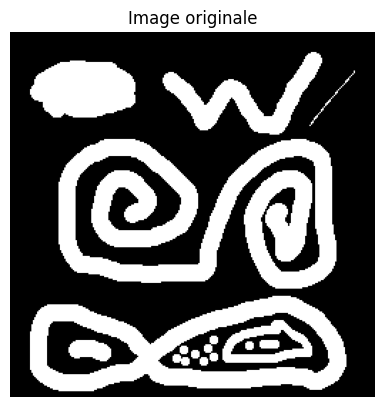

In [10]:
# Charger l'image de test
image = load_binary_image('binary.png')
print(f"Image chargée: {image.shape[0]}x{image.shape[1]} pixels")
print(f"Pixels blancs: {np.sum(image == 1)}, Pixels noirs: {np.sum(image == 0)}")

# Créer les éléments structurants carrés
se_square_3 = create_square_se(3)
se_square_5 = create_square_se(5)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Image originale')
plt.axis('off')


plt.tight_layout()
plt.show()

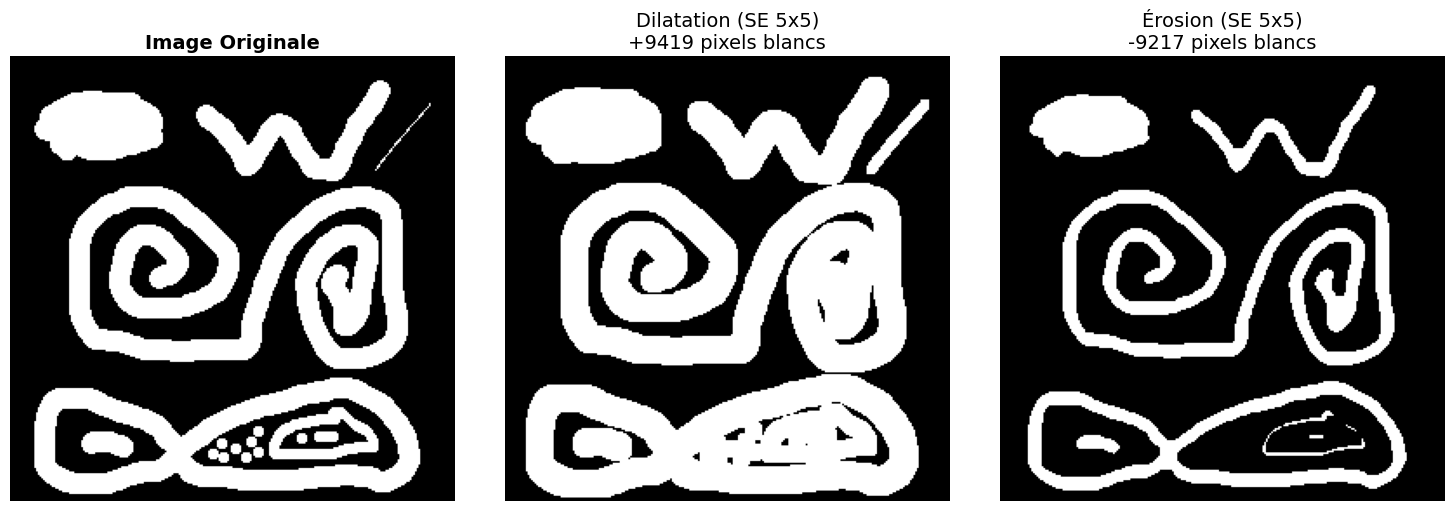

In [11]:
# Test Dilatation et Érosion
se = se_square_5

dilated = dilate(image, se)
eroded = erode(image, se)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(image, cmap='gray')
axes[0].set_title('Image Originale', fontsize=14, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(dilated, cmap='gray')
axes[1].set_title(f'Dilatation (SE 5x5)\n+{int(np.sum(dilated) - np.sum(image))} pixels blancs', fontsize=14)
axes[1].axis('off')

axes[2].imshow(eroded, cmap='gray')
axes[2].set_title(f'Érosion (SE 5x5)\n-{int(np.sum(image) - np.sum(eroded))} pixels blancs', fontsize=14)
axes[2].axis('off')

plt.tight_layout()
plt.savefig('../results/comparison_dilation_erosion.png', dpi=150, bbox_inches='tight')
plt.show()

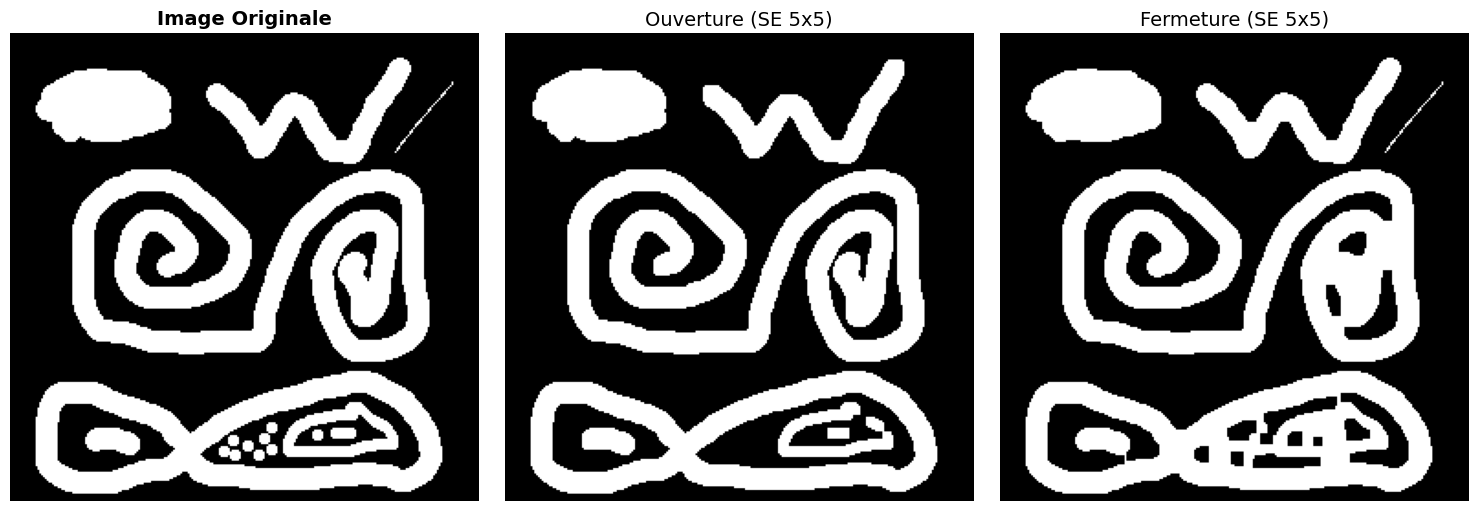

In [14]:
# Test Ouverture et Fermeture
se = se_square_5

opened = open_morphology(image, se)
closed = close_morphology(image, se)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(image, cmap='gray')
axes[0].set_title('Image Originale', fontsize=14, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(opened, cmap='gray')
axes[1].set_title('Ouverture (SE 5x5)', fontsize=14)
axes[1].axis('off')

axes[2].imshow(closed, cmap='gray')
axes[2].set_title('Fermeture (SE 5x5)', fontsize=14)
axes[2].axis('off')

plt.tight_layout()
plt.show()

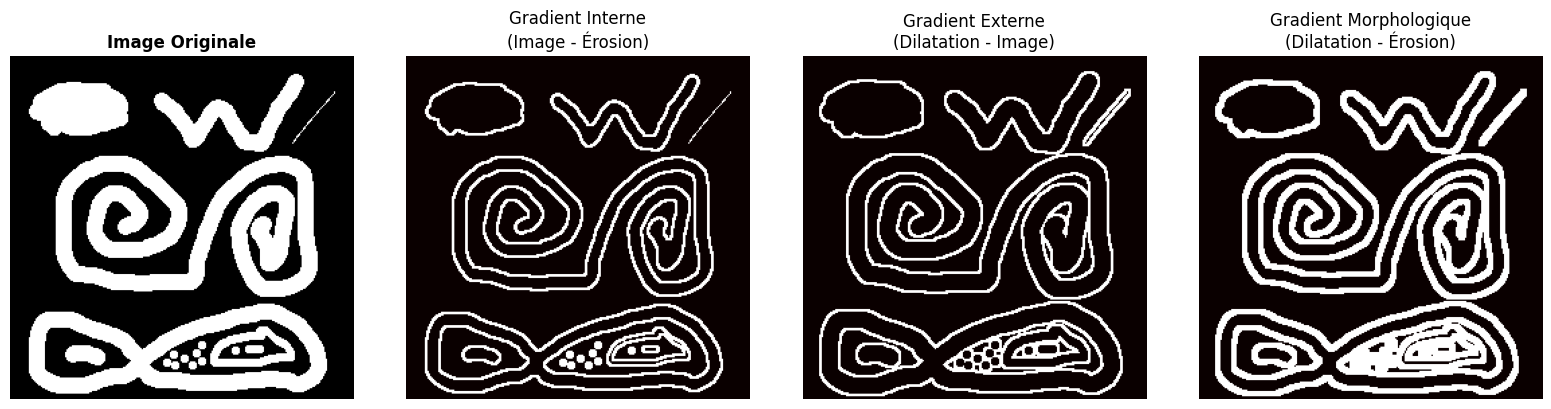

In [12]:
# Test Gradient Morphologique
se = se_square_5

gradient = morphological_gradient(image, se)
internal_gradient = image - erode(image, se)  # Gradient interne
external_gradient = dilate(image, se) - image  # Gradient externe

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

axes[0].imshow(image, cmap='gray')
axes[0].set_title('Image Originale', fontsize=12, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(internal_gradient, cmap='hot')
axes[1].set_title('Gradient Interne\n(Image - Érosion)', fontsize=12)
axes[1].axis('off')

axes[2].imshow(external_gradient, cmap='hot')
axes[2].set_title('Gradient Externe\n(Dilatation - Image)', fontsize=12)
axes[2].axis('off')

axes[3].imshow(gradient, cmap='hot')
axes[3].set_title('Gradient Morphologique\n(Dilatation - Érosion)', fontsize=12)
axes[3].axis('off')

plt.tight_layout()
plt.show()

In [16]:
# Sauvegarder tous les résultats
print("Sauvegarde des résultats...")

# Avec SE carré 3x3
save_result(dilate(image, se_square_3), 'binary_dilated_square3.png')
save_result(erode(image, se_square_3), 'binary_eroded_square3.png')
save_result(open_morphology(image, se_square_3), 'binary_opened_square3.png')
save_result(close_morphology(image, se_square_3), 'binary_closed_square3.png')
save_result(morphological_gradient(image, se_square_3), 'binary_gradient_square3.png')

# Avec SE carré 5x5
save_result(dilate(image, se_square_5), 'binary_dilated_square5.png')
save_result(erode(image, se_square_5), 'binary_eroded_square5.png')
save_result(open_morphology(image, se_square_5), 'binary_opened_square5.png')
save_result(close_morphology(image, se_square_5), 'binary_closed_square5.png')
save_result(morphological_gradient(image, se_square_5), 'binary_gradient_square5.png')

print("\nTerminé!")

Sauvegarde des résultats...
Image sauvegardée: ..\results\binary_dilated_square3.png
Image sauvegardée: ..\results\binary_eroded_square3.png
Image sauvegardée: ..\results\binary_opened_square3.png
Image sauvegardée: ..\results\binary_closed_square3.png
Image sauvegardée: ..\results\binary_gradient_square3.png
Image sauvegardée: ..\results\binary_dilated_square5.png
Image sauvegardée: ..\results\binary_eroded_square5.png
Image sauvegardée: ..\results\binary_opened_square5.png
Image sauvegardée: ..\results\binary_closed_square5.png
Image sauvegardée: ..\results\binary_gradient_square5.png

Terminé!
